In [ ]:
# MNIST Dataset

# Import to grab popular ML datasets
from sklearn.datasets import fetch_openml

# Grab MNIST
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
# Datasets grabbed by sklearn often have a similar dictionary strucutre containing
# 1. DESCR key describing the dataset
# 2. data key containing an array with one row per instance and one column per feature
# 3. target key containing an array with the labels

# Display arrays
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

# 70,000 images with 784 features

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot out image (28 x 28) into an array with matplotlib
some_digit = X[0]
some_digital_image = some_digit.reshape(28,28)

plt.imshow(some_digital_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show
print(y[0])

In [ ]:
# Cast y string variables into int variables
import numpy as np
y = y.astype(np.uint8)


In [ ]:
# Create test/train sets
# Note: All sets are already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]



In [ ]:
# Create binary classifier for 5
y_train_5 = (y_train == 5) # True for 5, false for non-5
y_test_5 = (y_test == 5)

# Training classifier
from sklearn.linear_model import SGDClassifier

# SGDCLassifier model
# Note: very good at online learning
sgd_clf = SGDClassifier(random_state=42)
# Fit model
sgd_clf.fit(X_train, y_train_5)



In [ ]:
# Predict first image in array representing 5
sgd_clf.predict([some_digit])

# Correctly predicts the number 5

In [ ]:
# Evaluate performance of SGDClassifier model at current time
# It is more difficult to predict accuracy of classifier models than regressor models
# Many different evaluation measures will be shown

# Measuring accuracy using cross-validation
# Similarly used in Chp_2 project
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# In order to gain more control in this cross-validation process the following code implements
# cross-validation manually

# Random_state ensures repeatable outputs. 42 is generally used
skfolds = StratifiedKFold(n_splits=3, random_state=42)

# StratifiedKFold performs stratified sampling (expl. chp. 2)
# at each iteration the code creates a clone of the classifier, trains the clone on the training folds, and makes predictions on the
# test fold
# then it counts the number of correct predictions and outputs the ratio of correct predictions
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Output ratio of correct predictions
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # 0.95035, 0.96035, 0.9604

In [ ]:
# cross_val_score to gauge accuracy (same as code above)
from sklearn.model_selection import cross_val_score

# See Chp 2 for further information
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 0.95035, 0.96035, 0.9604

In [ ]:
# Dumb classifier that will look at every image in not-5 category
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# returns 0.91125, 0.90855, 0.90915
# About 10% of the images are 5. So if you guess that an image is 'not-5' you will be right about 90% of the time
# Accuracy is not generally a good indicator for classification models

In [ ]:
# Confusion Matrix -- more ideal method of calculating classifier performance
# Essentially counts the number of times instances of class A are classified as class B
# e.g knowing the amount of times the classifier confused images of 5s with 3s

# Initial step -- calculate set of predictions
from sklearn.model_selection import cross_val_predict

# cross_val_predict is similar to cross_val_score
# performs k fold cross-validation but calculates predictions instead of scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)



In [ ]:
# Confusion matrix creation
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) # returns 53892, 687 (next row) 1891, 3530
# each row represents an actual class, while each column represents a predicted class
# Row 1: Correctly guessed non-5's, then false positives (incorrectly guessed as 5)
# Row 2: False negatives (wrongly classified as non5s), then true positives (correctly classified as 5)
# A perfect model would only have true negatives and true positives

In [ ]:
y_train_perfect_predictions = y_train_5 # pretending that the model has reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions) # Confusion matrix based on a 'perfect model' with our data

In [ ]:
# Precision calculations
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # Precision score, usually used in conjunction with recall score
print(recall_score(y_train_5, y_train_pred)) # recall score

# Precision score:  TP / (TP + FP)
# Recall score: TP / (TP + FN)

# Prints 0.83708 ...
# Prints 0.651171 ...

In [ ]:
# The F1 score is the harmonic mean between the precision score and recall score

# F1 score:
# 2/(1/precision + 1/recall)
# Code for F1 Score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

In [ ]:
# The decision threshhold for the classifier cannot be changed directly
# However, the decision scores that it uses to make predictions can be accessed

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # Print 2164.2203 ...

threshhold = 0
y_some_digit_pred = (y_scores > threshhold)
print(y_some_digit_pred) # Print array [ True]


In [ ]:
threshhold = 8000 
y_some_digit_pred = (y_scores > threshhold) # Boolean value for testing threshold vs score
# when score is higher than threshhold it is true
print(y_some_digit_pred)

In [ ]:
# Finding the right decision score to use across all instances
# not just [0]
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # return decision scores

from sklearn.metrics import precision_recall_curve

precisions, recalls, threshholds = precision_recall_curve(y_train_5, y_scores) # Compue precision and recall for all possible threshholds

# Function for plotting precision and recall
# Graph can be used for precision / recall tradeoff calculations
def plot_precision_recall_vs_threshhold(precisions,recalls,threshholds):
    plt.plot(threshholds, precisions[:-1], "b--", label="Precision")
    plt.plot(threshholds,recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshhold(precisions,recalls,threshholds) 
plt.show()


In [ ]:
# With a goal of 90% precision, the exact threshhold value can be calculated
threshhold_90_precision = threshholds[np.argmax(precisions >= 0.90)]
print(threshhold_90_precision) # prints 3370.019

# Make predictions on the training set
y_train_pred_90 = (y_scores >= threshhold_90_precision) # create boolean

print(precision_score(y_train_5, y_train_pred_90)) # precision using boolean -- print 0.9000345
print(recall_score(y_train_5, y_train_pred_90)) # recall using boolean -- print 0.479985

In [ ]:
# ROC Curve from sklearn.metrics
from sklearn.metrics import roc_curve

fpr, tpr, threshholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # dashed diagonal

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
# AUC (area under the curve)
# perfect classifier has AUC == 1 && ROC == 1
# completely random classifier has AUC == 0.5 && ROC == 0.5
roc_auc_score(y_train_5, y_scores) # print 0.960493 ...



In [ ]:
# Training RandomForestClassifier to compare ROC and ROC/AUC to SGDClassifier ROC ROC/AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) # Create model
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba") # Gather probabilities

y_scores_forest = y_probas_forest[:,1] # Gather scores
fpr_forest,tpr_forest,threshholds_forest = roc_curve(y_train_5,y_scores_forest) # Info for plotting ROC

In [ ]:
# Compare SGD to Random Forest
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5,y_scores_forest) # print 0.998343

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) # prediction variable
print(precision_score(y_train_5, y_train_pred_forest)) # prints 0.990508
print(recall_score(y_train_5, y_train_pred_forest)) # prints 0.86626

In [ ]:
# multiclass classifiers -- e.g comparing more than two classes. (as opposed to binary classifiers that compare 2 options)
# multiclass operations can be conducted by using multiple binary class classifiers (one versus all strategy OvA / or one verses one OvO)
'''
Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).
'''

# Testing scikit-learn's detection operation -- trains SGDClassifier on the training set using the
# the original target classes from 0 to 9 (y_train), instead of 5 v all target classes (y_train_5)
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

# decision_function method -- returns 10 scores per instance instead of just one per instance (trained 10 classifiers)
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

In [ ]:
# Highest score on some_digit_scores corresponds to 5
print(np.argmax(some_digit_scores)) # returns highest prediction for some_digit_scores e.g [some_digit]

print(sgd_clf.classes_) # all classes

print(sgd_clf.classes_[5]) # fifth class

In [ ]:
# To change strategies using scikit-learn (OvA or OvO) you can use the OneVsOneClassifier or OneVsRestCLassifier classes
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42)) # Create model using OvO/SGDClassifier
ovo_clf.fit(X_train,y_train) # Fit model
print(ovo_clf.predict([some_digit])) # predict [some_digit]
print(len(ovo_clf.estimators_)) # Print out length of all estimators (in this case 45)

In [ ]:
# RandomForestClassifier model using OvO
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

'''
This time Scikit-Learn did not have to run OvA or OvO because Random Forest
classifiers can directly classify instances into multiple classes. 
'''

In [ ]:
# Call predict_proba() to get a list of probabilities that the classifer assigned to each instance for each class (random forest)
print(forest_clf.predict_proba([some_digit])) # 90% confidence the image is a 5


In [ ]:
# Evaluate the new classifiers

print(cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")) # [0.87365 0.85835 0.8689 ]

# Increased performance can be recieved by scaling inputs


In [ ]:
# scaling inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Create scaler
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # Fit scaler
print(cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")) # Print score -- [0.8983 0.891  0.9018]

In [ ]:
# Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) # 
conf_mx = confusion_matrix(y_train, y_train_pred) # confusion matrix: p. 92-94
print(conf_mx)

In [ ]:
# plot conf_mx
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# The 5 square is a bit darker than the rest of the diagonal squares, which either means their are less in the dataset or
# the classifier is less accurate on fives

In [ ]:
# focus plot on errors
# divide each value in the confusion matrix by the number of images in the corresponding class, to compare error rates

row_sums = conf_mx.sum(axis=1,keepdims=True) 
norm_conf_mx = conf_mx / row_sums # calc rate

np.fill_diagonal(norm_conf_mx,0) # p. 106
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show() # confusion matrix shows falsely classified images are mostly falsely classified as 8's when they are not
# information shown on page 106 & in hands_on_ml_notes.py

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
# Examples of 3's and 5's
cl_a,cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
# Multi-label classification

from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier == multi-label capabilities

y_train_large = (y_train >= 7) # is selected digit >= 7
y_train_odd = (y_train % 2 == 1) # is selected digit odd
y_multilabel = np.c_[y_train_large, y_train_odd] # np array containing two target labels for each selected digit

knn_clf = KNeighborsClassifier() # Create model
knn_clf.fit(X_train, y_multilabel) # Fit model

In [ ]:
knn_clf.predict([some_digit]) # Predict using KNeighborsClassifier
# returns y_multilabel np array containing multi-label predictions for selected digits

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3) # Predict using cross_val_predict
f1_score(y_multilabel,y_train_knn_pred,average="macro") # compute average f1 score
# to set weights use average="weighted"

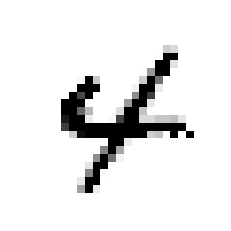

In [45]:
# multi-output multiclass classification (or multioutput classification)

# *************************************
# Create model that takes noise out of digital images :

# create training/test sets using MNIST images
noise = np.random.randint(0,100,(len(X_train),784)) # Create pixel noise
X_train_mod = X_train + noise # New X_train with added noise
noise = np.random.randint(0, 100, (len(X_test), 784)) # Create pixel noise
X_test_mod = X_test + noise # New X_test with pixel noise
y_train_mod = X_train
y_test_mod = X_test
some_index = 5500

knn_clf.fit(X_train_mod, y_train_mod) # fit model
clean_digit = knn_clf.predict([X_test_mod[some_index]]) # predict test mod 5500
plot_digits(clean_digit) # plot


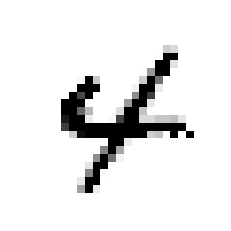

In [46]:
knn_clf.fit(X_train_mod, y_train_mod) # fit model
clean_digit = knn_clf.predict([X_test_mod[some_index]]) # Predict test mod 5500
plot_digits(clean_digit) # plot

# ********************************